<a href="https://colab.research.google.com/github/DarshanSuresh/Academic_Stress_Levels_in_UG_Students_using_ML_Models/blob/main/Measuring_the_Impact_of_Meditation_on_Academic_Stress_Levels_in_UG_Students_using_Machine_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [80]:
import pandas as pd
import numpy as np
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')



## Data Loading and Ingestion

In [79]:
df = pd.read_csv('/content/Final_684_Merged_Cleaned - Sheet1.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())


Dataset Shape: (683, 23)

Column Names:
['A. Enter your age', 'A. Enter your Gender', 'B. Frequency of Meditation:', 'B. Average Duration of each meditation session:', 'B. Type of Meditation practiced:', 'PRE1. I feel stressed about academic deadlines and exams.', 'PRE2. I struggle to concentrate on studies due to stress.', 'PRE3. Meditation does not help reduce my stress.', 'PRE4. I often feel anxious before tests or assignments.', 'PRE5. I can manage multiple academic tasks without feeling overwhelmed.', 'PRE6. Stress negatively affects my academic performance.', 'PRE7. I feel calm and focused during study sessions.', 'POST1. I feel stressed about academic deadlines and exams.', 'POST2. I struggle to concentrate on studies due to stress.', 'POST3. Meditation does not help reduce my stress.', 'POST4. I often feel anxious before tests or assignments.', 'POST5. I can manage multiple academic tasks without feeling overwhelmed.', 'POST6. Stress negatively affects my academic performance.'

## Preprocessing Dataset

In [82]:
# Data Cleaning and Preprocessing
print("DATA PREPROCESSING AND CLEANING")

# Remove outliers using Z-score method (age > 50 is unrealistic for students)
df_clean = df[df['A. Enter your age'] <= 50].copy()
print(f"Original dataset size: {len(df)}")
print(f"After removing age outliers: {len(df_clean)}")

# Encode categorical variables
le_gender = LabelEncoder()
le_frequency = LabelEncoder()
le_duration = LabelEncoder()
le_type = LabelEncoder()

df_clean['Gender_encoded'] = le_gender.fit_transform(df_clean['A. Enter your Gender'])
df_clean['Frequency_encoded'] = le_frequency.fit_transform(df_clean['B. Frequency of Meditation:'])
df_clean['Duration_encoded'] = le_duration.fit_transform(df_clean['B. Average Duration of each meditation session:'])
df_clean['Type_encoded'] = le_type.fit_transform(df_clean['B. Type of Meditation practiced:'])

print("\nCategorical Encoding Summary:")
print(f"Gender classes: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")
print(f"Frequency classes: {dict(zip(le_frequency.classes_, le_frequency.transform(le_frequency.classes_)))}")
print(f"Duration classes: {dict(zip(le_duration.classes_, le_duration.transform(le_duration.classes_)))}")
print(f"Type classes: {dict(zip(le_type.classes_, le_type.transform(le_type.classes_)))}")

# Normalize continuous features
scaler = MinMaxScaler()
features_to_normalize = ['A. Enter your age', 'PRE_total', 'POST_total', 'stress_change']
normalized_features = scaler.fit_transform(df_clean[features_to_normalize])
for i, col in enumerate(features_to_normalize):
    df_clean[col + '_norm'] = normalized_features[:, i]

print("\nNormalization (Min-Max Scaling) applied to continuous features")
print(f"Age range after normalization: [{df_clean['A. Enter your age_norm'].min():.3f}, {df_clean['A. Enter your age_norm'].max():.3f}]")

# Create stress level categories (Low, Medium, High) based on PRE_total
df_clean['stress_category_pre'] = pd.cut(df_clean['PRE_total'],
                                          bins=[0, 15, 22, 35],
                                          labels=['Low', 'Medium', 'High'])
df_clean['stress_category_post'] = pd.cut(df_clean['POST_total'],
                                           bins=[0, 15, 22, 35],
                                           labels=['Low', 'Medium', 'High'])

print("\nStress Categories Distribution (PRE-intervention):")
print(df_clean['stress_category_pre'].value_counts())
print("\nStress Categories Distribution (POST-intervention):")
print(df_clean['stress_category_post'].value_counts())

# Encode stress categories
le_stress = LabelEncoder()
df_clean['stress_category_pre_encoded'] = le_stress.fit_transform(df_clean['stress_category_pre'].astype(str))
df_clean['stress_category_post_encoded'] = le_stress.transform(df_clean['stress_category_post'].astype(str))

# Create treatment variable: 1 if meditating (Frequency > 0 days/week), 0 otherwise
df_clean['treatment'] = (~df_clean['B. Frequency of Meditation:'].str.contains('0 days')).astype(int)

print("\nTreatment Distribution (Meditation Practitioners):")
print(df_clean['treatment'].value_counts())
print(f"Treatment effect distribution: {df_clean['treatment'].mean()*100:.1f}% are meditation practitioners")

# Save cleaned data
df_clean.to_csv('preprocessed_meditation_data.csv', index=False)
print("\nPreprocessed data saved to 'preprocessed_meditation_data.csv'")


DATA PREPROCESSING AND CLEANING
Original dataset size: 683
After removing age outliers: 680

Categorical Encoding Summary:
Gender classes: {'Female': np.int64(0), 'Male': np.int64(1), 'Prefer not to say': np.int64(2)}
Frequency classes: {'0 days/week': np.int64(0), '1-2 days/week': np.int64(1), '3-4 days/week': np.int64(2), '5-6 days/week': np.int64(3), 'Daily': np.int64(4)}
Duration classes: {'15-30 mins': np.int64(0), '30-60 mins': np.int64(1), '5-15 mins': np.int64(2), 'Less than 5 mins': np.int64(3), 'More than 60 mins': np.int64(4)}
Type classes: {'Breath-based (Pranayama)': np.int64(0), 'Mantra-based': np.int64(1), 'Mindfullness/Awareness': np.int64(2), 'Moving Meditation (like Tai-Chi, Yoga, etc)': np.int64(3)}

Normalization (Min-Max Scaling) applied to continuous features
Age range after normalization: [0.000, 1.000]

Stress Categories Distribution (PRE-intervention):
stress_category_pre
Medium    357
High      287
Low        36
Name: count, dtype: int64

Stress Categories Dis

## K-Nearest Neighbors

In [83]:
# Continue with K-Nearest Neighbors (KNN) Classification
print("K-NEAREST NEIGHBORS (KNN) CLASSIFICATION")

# Prepare features for supervised learning
feature_cols = ['A. Enter your age_norm', 'Gender_encoded', 'Frequency_encoded',
                'Duration_encoded', 'Type_encoded', 'PRE_total_norm']
X = df_clean[feature_cols]
y = df_clean['stress_category_post_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Train KNN with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluate KNN
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"\nKNN (k=5) Accuracy: {knn_accuracy:.4f}")

print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Low', 'Medium', 'High']))

# Cross-validation for KNN
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(f"\nKNN 10-Fold Cross-Validation Scores: {cv_scores_knn}")
print(f"KNN Cross-Validation Mean Accuracy: {cv_scores_knn.mean():.4f} (+/- {cv_scores_knn.std():.4f})")


K-NEAREST NEIGHBORS (KNN) CLASSIFICATION
Training set size: 544
Test set size: 136

KNN (k=5) Accuracy: 0.7721

KNN Confusion Matrix:
[[36  0 13]
 [ 2  4  6]
 [ 9  1 65]]

KNN Classification Report:
              precision    recall  f1-score   support

         Low       0.77      0.73      0.75        49
      Medium       0.80      0.33      0.47        12
        High       0.77      0.87      0.82        75

    accuracy                           0.77       136
   macro avg       0.78      0.64      0.68       136
weighted avg       0.77      0.77      0.76       136


KNN 10-Fold Cross-Validation Scores: [0.65454545 0.56363636 0.63636364 0.61818182 0.64814815 0.66666667
 0.74074074 0.59259259 0.5        0.61111111]
KNN Cross-Validation Mean Accuracy: 0.6232 (+/- 0.0611)


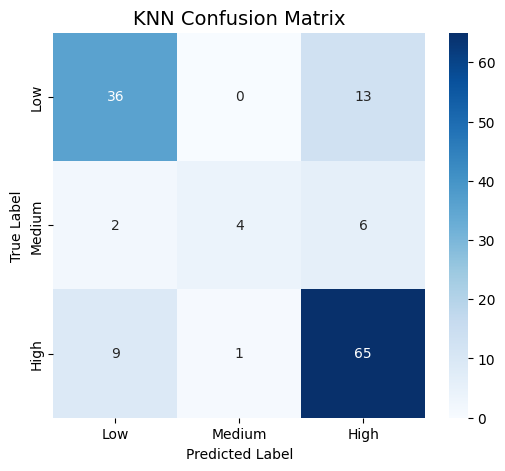

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('KNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


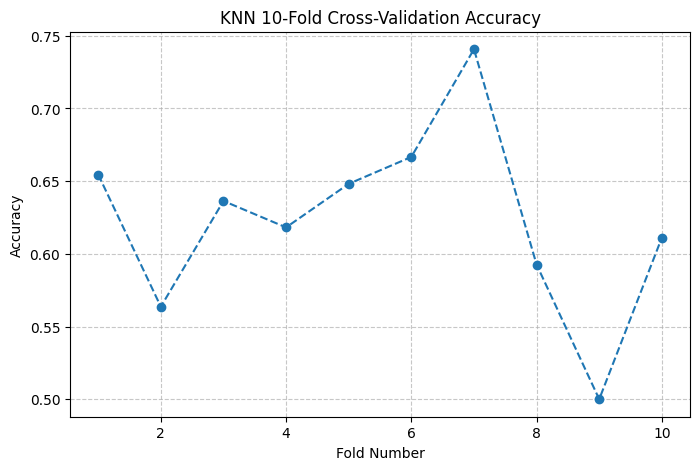

Mean CV Accuracy: 0.6232


In [38]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cv_scores_knn, marker='o', linestyle='--')
plt.title('KNN 10-Fold Cross-Validation Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Mean CV Accuracy: {cv_scores_knn.mean():.4f}")


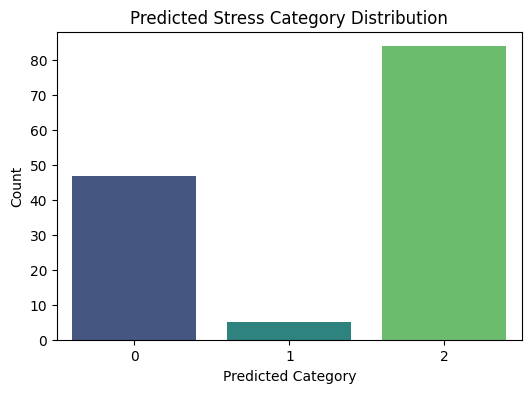

In [39]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred_knn, palette='viridis')
plt.title('Predicted Stress Category Distribution')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.show()


## SVM

In [7]:

# Support Vector Machine (SVM) Classification
print("\n" + "="*80)
print("STEP 3: SUPPORT VECTOR MACHINE (SVM) CLASSIFICATION")
print("="*80)

# Train SVM with RBF kernel
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM (RBF kernel) Accuracy: {svm_accuracy:.4f}")

print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Low', 'Medium', 'High']))

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm, X_train, y_train, cv=10, scoring='accuracy')
print(f"\nSVM 10-Fold Cross-Validation Scores: {cv_scores_svm}")
print(f"SVM Cross-Validation Mean Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std():.4f})")



STEP 3: SUPPORT VECTOR MACHINE (SVM) CLASSIFICATION
SVM (RBF kernel) Accuracy: 0.6397

SVM Confusion Matrix:
[[14  0 35]
 [ 1  0 11]
 [ 2  0 73]]

SVM Classification Report:
              precision    recall  f1-score   support

         Low       0.82      0.29      0.42        49
      Medium       0.00      0.00      0.00        12
        High       0.61      0.97      0.75        75

    accuracy                           0.64       136
   macro avg       0.48      0.42      0.39       136
weighted avg       0.64      0.64      0.57       136


SVM 10-Fold Cross-Validation Scores: [0.6        0.54545455 0.74545455 0.63636364 0.55555556 0.57407407
 0.61111111 0.61111111 0.61111111 0.66666667]
SVM Cross-Validation Mean Accuracy: 0.6157 (+/- 0.0552)


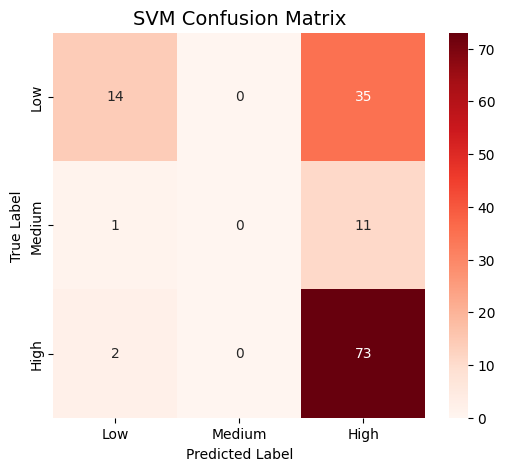

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title('SVM Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


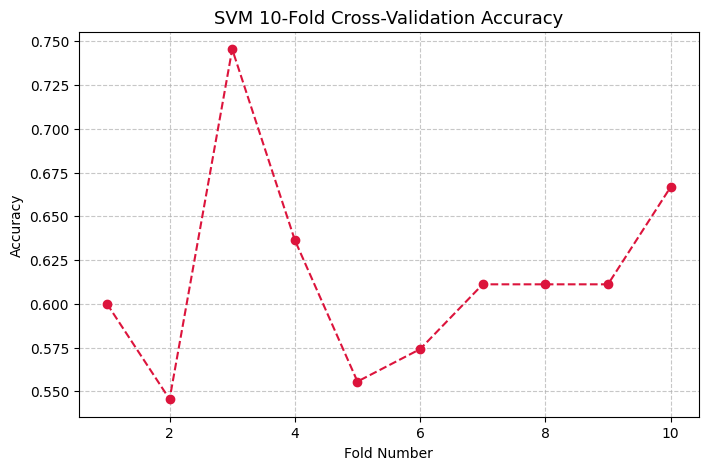

Mean CV Accuracy: 0.6157


In [41]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cv_scores_svm, marker='o', linestyle='--', color='crimson')
plt.title('SVM 10-Fold Cross-Validation Accuracy', fontsize=13)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Mean CV Accuracy: {cv_scores_svm.mean():.4f}")


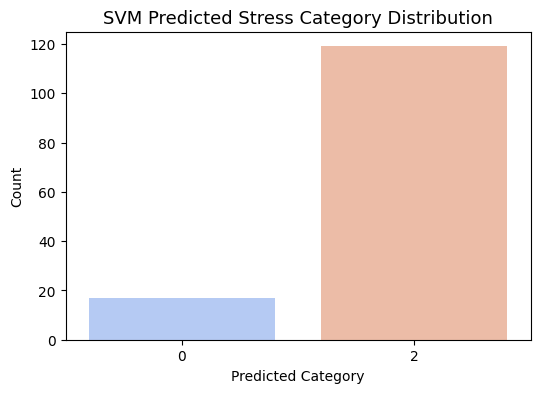

In [42]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred_svm, palette='coolwarm')
plt.title('SVM Predicted Stress Category Distribution', fontsize=13)
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.show()


## Random Forest

In [8]:

# Random Forest Classification
print("\n" + "="*80)
print("STEP 4: RANDOM FOREST CLASSIFICATION")
print("="*80)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Low', 'Medium', 'High']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')
print(f"\nRandom Forest 10-Fold Cross-Validation Scores: {cv_scores_rf}")
print(f"Random Forest Cross-Validation Mean Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")



STEP 4: RANDOM FOREST CLASSIFICATION
Random Forest Accuracy: 0.8824

Random Forest Confusion Matrix:
[[40  0  9]
 [ 0  8  4]
 [ 3  0 72]]

Random Forest Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.82      0.87        49
      Medium       1.00      0.67      0.80        12
        High       0.85      0.96      0.90        75

    accuracy                           0.88       136
   macro avg       0.93      0.81      0.86       136
weighted avg       0.89      0.88      0.88       136


Feature Importance (Random Forest):
                  Feature  Importance
5          PRE_total_norm    0.525884
0  A. Enter your age_norm    0.144719
2       Frequency_encoded    0.097524
4            Type_encoded    0.095512
3        Duration_encoded    0.086791
1          Gender_encoded    0.049570

Random Forest 10-Fold Cross-Validation Scores: [0.90909091 0.72727273 0.87272727 0.87272727 0.85185185 0.77777778
 0.85185185 0.85185185 0

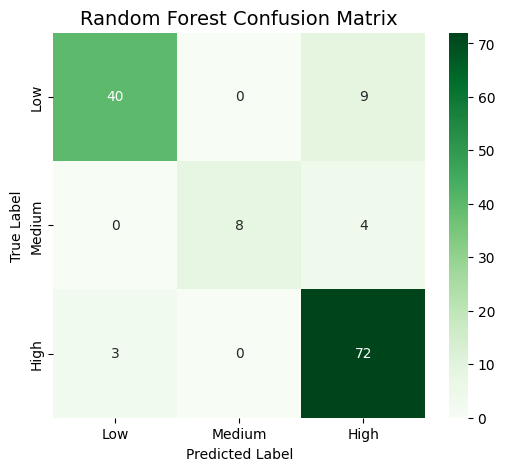

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Random Forest Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


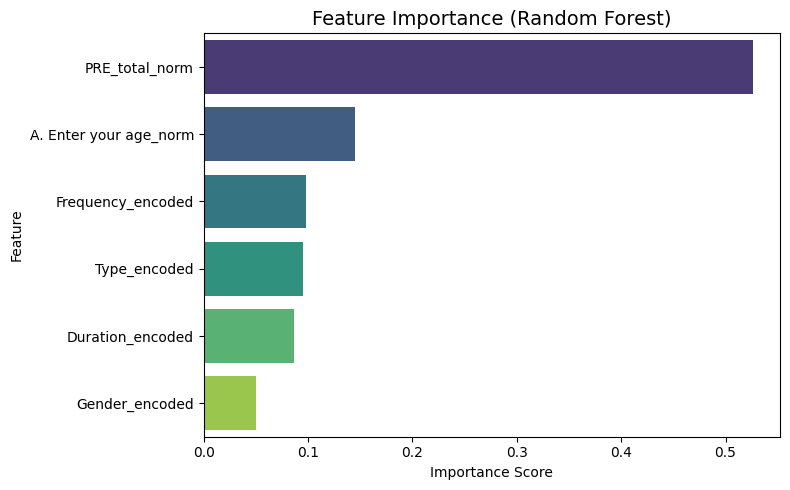

In [44]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


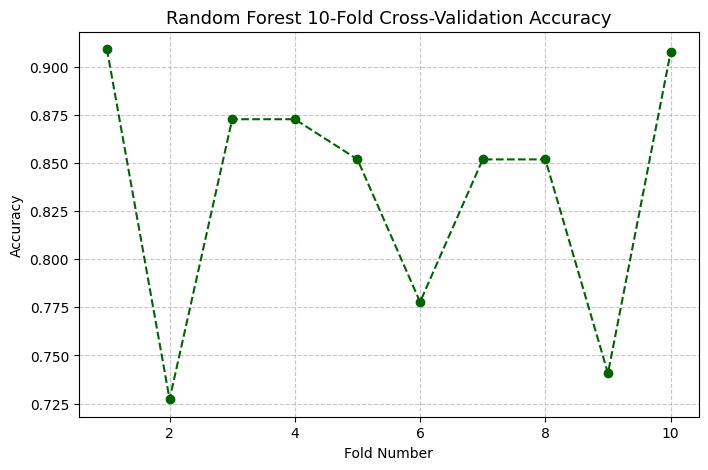

Mean CV Accuracy: 0.8363


In [45]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), cv_scores_rf, marker='o', linestyle='--', color='darkgreen')
plt.title('Random Forest 10-Fold Cross-Validation Accuracy', fontsize=13)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f}")


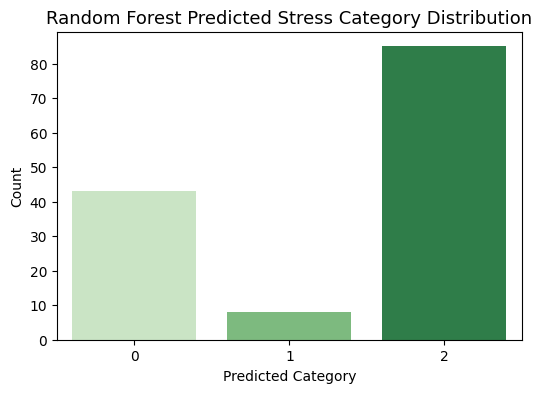

In [46]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred_rf, palette='Greens')
plt.title('Random Forest Predicted Stress Category Distribution', fontsize=13)
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.show()


### UNIFIED MODEL PERFORMANCE


FINAL MODEL PERFORMANCE COMPARISON
                       Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
   K-Nearest Neighbors (KNN)         78.10          78.17       78.10         78.07
Support Vector Machine (SVM)         64.96          64.95       64.96         64.94
               Random Forest         86.86          87.63       86.86         86.77


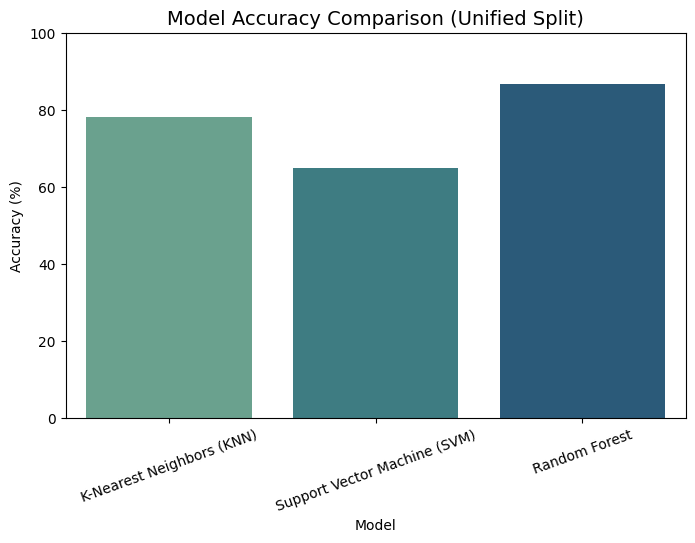

In [61]:
# ==============================================================
# STEP 4.6: UNIFIED MODEL PERFORMANCE COMPARISON (CLEAN VERSION)
# ==============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 1. Split data once, consistently
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 2. Train all three models on the same data
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# ✅ 3. Predict consistently
y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_rf  = rf.predict(X_test)

# ✅ 4. Define metrics function
def model_metrics(y_true, y_pred):
    return {
        'Accuracy (%)': accuracy_score(y_true, y_pred) * 100,
        'Precision (%)': precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100,
        'Recall (%)': recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100,
        'F1-Score (%)': f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    }

# ✅ 5. Build comparison table
comparison_df = pd.DataFrame([
    {'Model': 'K-Nearest Neighbors (KNN)', **model_metrics(y_test, y_pred_knn)},
    {'Model': 'Support Vector Machine (SVM)', **model_metrics(y_test, y_pred_svm)},
    {'Model': 'Random Forest', **model_metrics(y_test, y_pred_rf)},
])

# ✅ 6. Display results
print("\n" + "="*90)
print("FINAL MODEL PERFORMANCE COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False, float_format="%.2f"))
print("="*90)

# ✅ 7. Visualization
plt.figure(figsize=(8,5))
sns.barplot(data=comparison_df, x='Model', y='Accuracy (%)', palette='crest')
plt.title('Model Accuracy Comparison (Unified Split)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.show()


## Clustering -


STEP 5: K-MEANS CLUSTERING (VISUALIZATIONS)


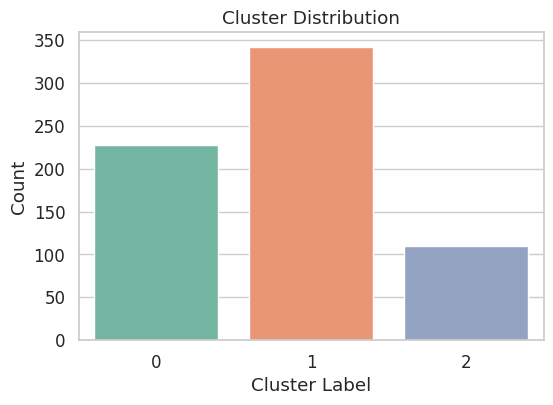

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("\n" + "="*80)
print("STEP 5: K-MEANS CLUSTERING (VISUALIZATIONS)")
print("="*80)

# ✅ Ensure 'cluster' column exists
if 'cluster' not in df_clean.columns:
    print("⚠️ 'cluster' column not found — creating it now.")
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_clean['cluster'] = kmeans.fit_predict(df_clean[feature_cols])

# 1️⃣ Cluster Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='cluster', data=df_clean, palette='Set2')
plt.title("Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()



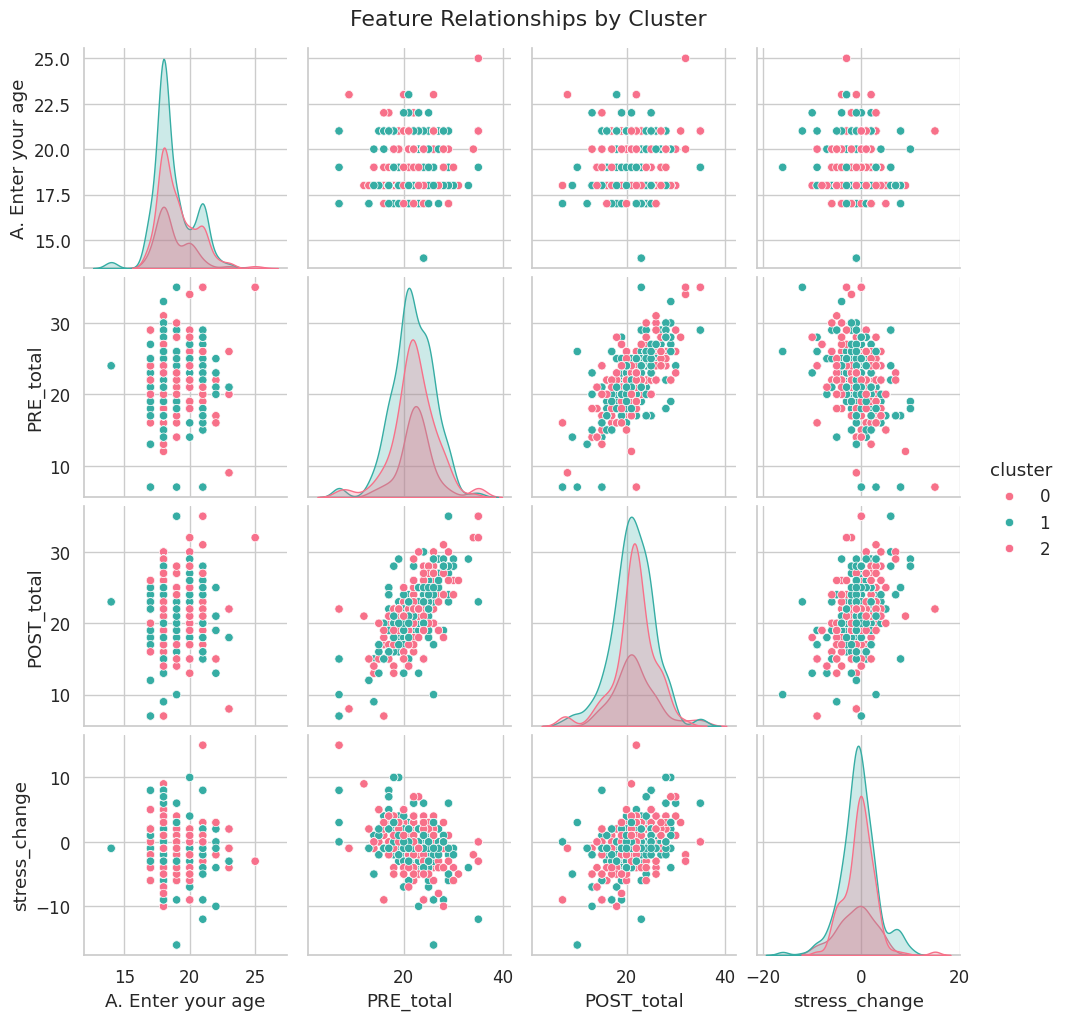

In [96]:

# 3️⃣ Pairplot of important features colored by cluster
subset_features = ['A. Enter your age', 'PRE_total', 'POST_total', 'stress_change', 'cluster']
sns.pairplot(df_clean[subset_features], hue='cluster', palette='husl', diag_kind='kde')
plt.suptitle("Feature Relationships by Cluster", y=1.02)
plt.show()


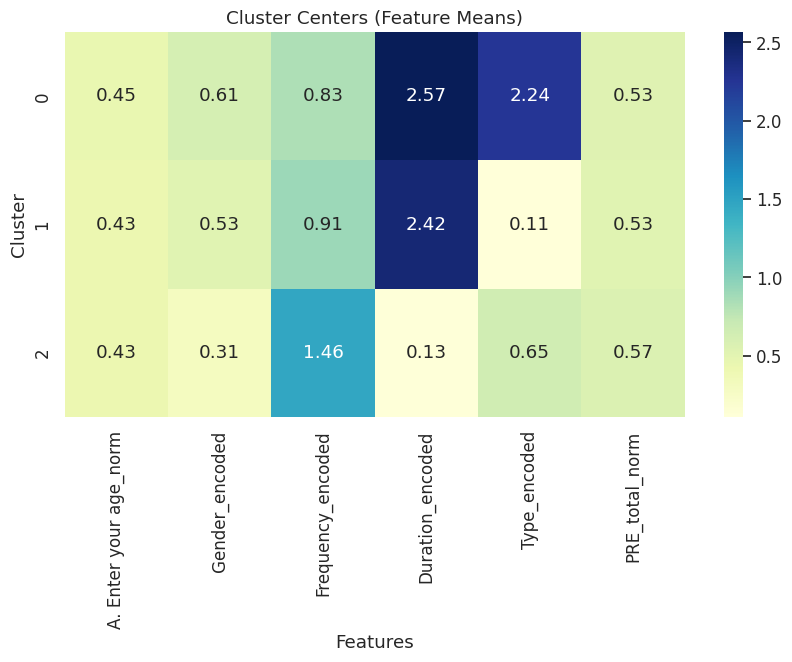


Adjusted Rand Index (ARI): -0.0074


In [97]:

# 4️⃣ Cluster centers visualization (means of each feature)
cluster_means = df_clean.groupby('cluster')[feature_cols].mean()

plt.figure(figsize=(10,5))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Cluster Centers (Feature Means)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.show()

# ARI comparison with true stress category
if 'stress_category_post_encoded' in df_clean.columns:
    from sklearn.metrics import adjusted_rand_score
    ari_score = adjusted_rand_score(df_clean['stress_category_post_encoded'], df_clean['cluster'])
    print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")
else:
    print("\n⚠️ 'stress_category_post_encoded' column not found. Skipping ARI calculation.")


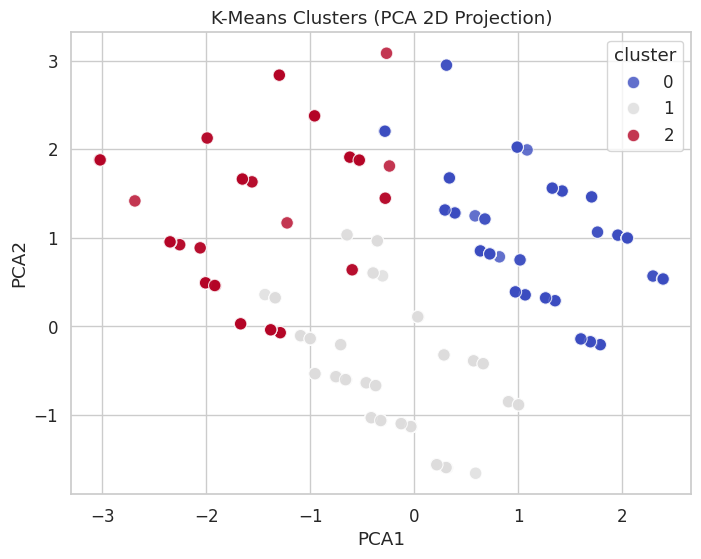

In [93]:
from sklearn.decomposition import PCA

if X_cluster.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(X_cluster)
    df_clean.loc[X_cluster.index, 'PCA1'] = pca_result[:, 0]
    df_clean.loc[X_cluster.index, 'PCA2'] = pca_result[:, 1]

    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_clean.loc[X_cluster.index],
                    x='PCA1', y='PCA2', hue='cluster',
                    palette='coolwarm', s=80, alpha=0.8)
    plt.title("K-Means Clusters (PCA 2D Projection)")
    plt.show()
else:
    print("⚠️ PCA skipped: Need at least 2 features, but got only", X_cluster.shape[1])


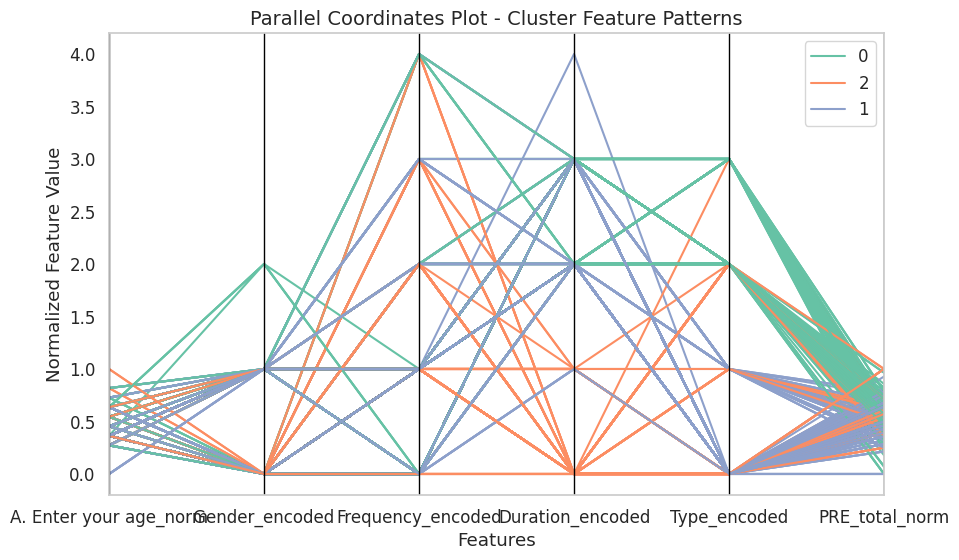

In [87]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(10,6))
parallel_coordinates(
    df_clean[['cluster'] + feature_cols].assign(cluster=df_clean['cluster'].astype(str)),
    'cluster',
    color=sns.color_palette("Set2", len(df_clean['cluster'].unique()))
)
plt.title("Parallel Coordinates Plot - Cluster Feature Patterns", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Normalized Feature Value")
plt.show()


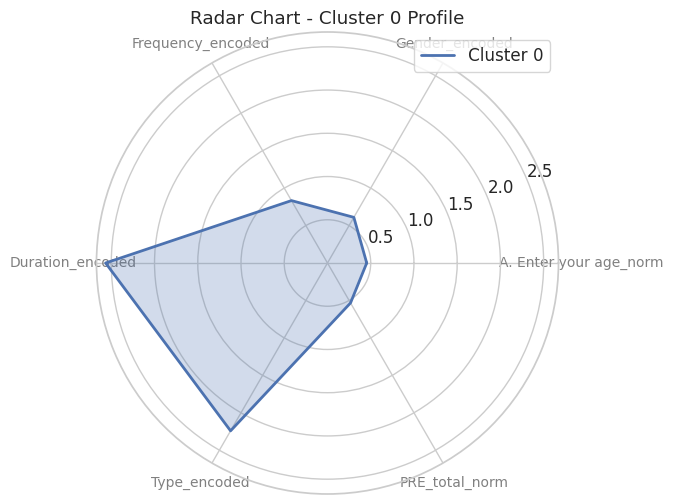

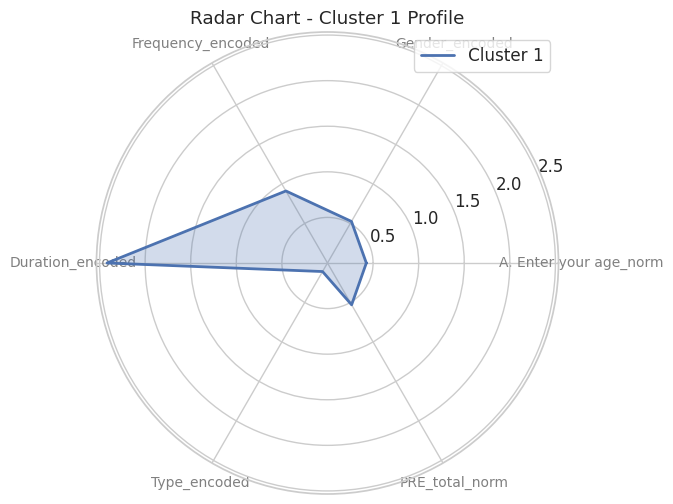

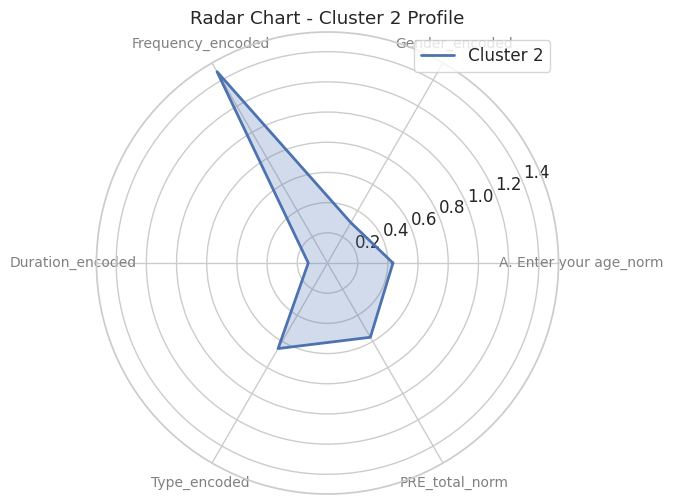

In [88]:
from math import pi

cluster_means = df_clean.groupby('cluster')[feature_cols].mean()

for cluster_id in cluster_means.index:
    values = cluster_means.loc[cluster_id].values.flatten().tolist()
    values += values[:1]  # repeat first value to close circle
    categories = list(cluster_means.columns)
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25)
    plt.title(f"Radar Chart - Cluster {cluster_id} Profile")
    plt.legend()
    plt.show()


In [92]:
# Ensure alignment between X_cluster and cluster labels
X_cluster = df_clean[feature_cols].copy()
X_cluster = X_cluster.dropna()

# Fit clustering on clean data
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

# Add cluster column to only the filtered rows
df_clean.loc[X_cluster.index, 'cluster'] = cluster_labels

# --- Now safely compute metrics ---
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

silhouette = silhouette_score(X_cluster, cluster_labels)
calinski = calinski_harabasz_score(X_cluster, cluster_labels)
davies = davies_bouldin_score(X_cluster, cluster_labels)

print("\nClustering Validation Metrics:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")
print(f"Davies-Bouldin Index: {davies:.4f}")



Clustering Validation Metrics:
Silhouette Score: 0.4034
Calinski-Harabasz Index: 395.6708
Davies-Bouldin Index: 1.0073


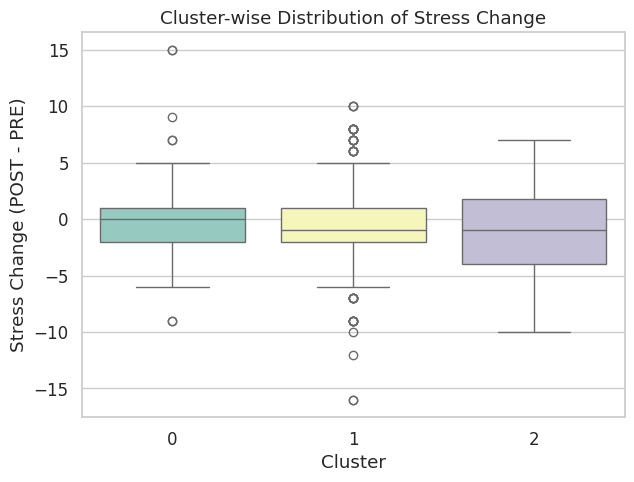

In [90]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df_clean, x='cluster', y='stress_change', palette='Set3')
plt.title("Cluster-wise Distribution of Stress Change")
plt.xlabel("Cluster")
plt.ylabel("Stress Change (POST - PRE)")
plt.show()


## Casual Forest - Main

In [56]:
pip install econml

### Causal Inference Analysis

#### Packages

In [116]:
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#### 1) Load / locate dataframe

In [117]:
if 'df' in globals():
    df_all = df.copy()
else:
    path = '/content/Final_684_Merged_Cleaned - Sheet1.csv'
    assert os.path.exists(path), f"File not found: {path}"
    df_all = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')

print("Loaded rows,cols:", df_all.shape)

Loaded rows,cols: (683, 24)


#### 2) Detect PRE/POST totals or compute them

In [112]:

pre_cols = [c for c in df_all.columns if c.strip().upper().startswith('PRE') and not c.strip().upper().endswith('TOTAL')]
post_cols = [c for c in df_all.columns if c.strip().upper().startswith('POST') and not c.strip().upper().endswith('TOTAL')]

# if there are PRE_total/POST_total columns use them
if 'PRE_total' in df_all.columns:
    df_all['PRE_total'] = pd.to_numeric(df_all['PRE_total'], errors='coerce')
elif any(c.strip().upper().endswith('PRE_TOTAL') for c in df_all.columns):
    # try to find variant
    for c in df_all.columns:
        if c.strip().upper().endswith('PRE_TOTAL'):
            df_all['PRE_total'] = pd.to_numeric(df_all[c], errors='coerce')
            break
elif len(pre_cols) >= 1:
    df_all[pre_cols] = df_all[pre_cols].apply(pd.to_numeric, errors='coerce')
    df_all['PRE_total'] = df_all[pre_cols].sum(axis=1)
else:
    raise RuntimeError("Cannot find PRE items or PRE_total in the dataframe.")

if 'POST_total' in df_all.columns:
    df_all['POST_total'] = pd.to_numeric(df_all['POST_total'], errors='coerce')
elif any(c.strip().upper().endswith('POST_TOTAL') for c in df_all.columns):
    for c in df_all.columns:
        if c.strip().upper().endswith('POST_TOTAL'):
            df_all['POST_total'] = pd.to_numeric(df_all[c], errors='coerce')
            break
elif len(post_cols) >= 1:
    df_all[post_cols] = df_all[post_cols].apply(pd.to_numeric, errors='coerce')
    df_all['POST_total'] = df_all[post_cols].sum(axis=1)
else:
    raise RuntimeError("Cannot find POST items or POST_total in the dataframe.")

# compute stress change: positive means improvement (PRE > POST)
df_all['stress_change'] = df_all['PRE_total'] - df_all['POST_total']  # positive -> reduced stress

print("PRE_total mean, POST_total mean:", df_all['PRE_total'].mean(), df_all['POST_total'].mean())
print("Stress change mean (positive => improvement):", df_all['stress_change'].mean())

PRE_total mean, POST_total mean: 21.973645680819914 21.43338213762811
Stress change mean (positive => improvement): 0.5402635431918009


#### 3) Define treatment variable

In [111]:
#    Preference order:
#      - 'meditation_freq_days' if present ( > 0 => treated)
#      - frequency column (string) -> map to numeric using freq_to_days()
#      - 'MISC3. Do you use meditation to cope exam/academic stress?' or similar
def freq_to_days(val):
    if pd.isna(val): return np.nan
    s = str(val).lower()
    if 'daily' in s or 'everyday' in s: return 7.0
    if '3-4' in s or '3 - 4' in s or '3 to 4' in s: return 3.5
    if '1-2' in s or '1 - 2' in s or '1 to 2' in s: return 1.5
    if 'none' in s or '0' in s: return 0.0
    if 'rare' in s: return 0.3
    if 'occasional' in s: return 1.0
    if 'frequent' in s: return 4.0
    if 'weekly' in s:
        m = re.search(r'(\d+)', s)
        return float(m.group(1)) if m else 1.0
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m: return float(m.group(1))
    return np.nan

# find candidate frequency column
freq_candidates = [c for c in df_all.columns if 'frequency' in c.lower() or 'freq' in c.lower() or 'frequency of meditation' in c.lower()]
if 'meditation_freq_days' in df_all.columns:
    df_all['meditation_freq_days'] = pd.to_numeric(df_all['meditation_freq_days'], errors='coerce')
elif freq_candidates:
    freq_col = freq_candidates[0]
    df_all['meditation_freq_days'] = df_all[freq_col].apply(freq_to_days)
else:
    df_all['meditation_freq_days'] = np.nan

# if exists, use boolean treatment = freq_days > 0
if df_all['meditation_freq_days'].notna().sum() > 0:
    df_all['treatment'] = (df_all['meditation_freq_days'] > 0).astype(int)
else:
    # fallback: look for MISC3 or similar 'Do you use meditation' columns
    use_cols = [c for c in df_all.columns if 'use meditation' in c.lower() or 'do you use meditation' in c.lower() or 'do you do meditation' in c.lower()]
    if use_cols:
        col = use_cols[0]
        df_all['treatment'] = df_all[col].astype(str).str.lower().map(lambda s: 1 if 'yes' in s or 'y' == s.strip() else 0)
    else:
        # final fallback: if there is 'Prior Meditation Experience:' use that
        prior_med = [c for c in df_all.columns if 'prior meditation' in c.lower()]
        if prior_med:
            df_all['treatment'] = df_all[prior_med[0]].astype(str).str.lower().map(lambda s: 1 if 'yes' in s or 'y' == s.strip() else 0)
        else:
            raise RuntimeError("Cannot detect a treatment column (meditation). Add 'meditation_freq_days' or a 'do you use meditation' column.")

print("Treatment counts:\n", df_all['treatment'].value_counts())


Treatment counts:
 treatment
1    486
0    197
Name: count, dtype: int64


#### 4) Covariates for propensity model / CATE

In [118]:
#    Use pre-treatment info only: PRE_total, (optionally PRE item responses), age, gender, program, etc.
possible_covs = []
# include numeric PRE items if present
possible_covs += [c for c in df_all.columns if c.strip().upper().startswith('PRE') and not c.strip().upper().endswith('TOTAL')]
# baseline aggregate
if 'PRE_total' in df_all.columns:
    possible_covs.append('PRE_total')
# demographics candidates
for cand in ['A. Enter your age', 'Enter your age', 'age', 'A. Enter your Gender', 'Enter your Gender', 'gender']:
    if cand in df_all.columns:
        possible_covs.append(cand)
# meditation prior / experience (pre-treatment)
for cand in df_all.columns:
    if 'prior meditation' in cand.lower() or 'prior med' in cand.lower() or 'prior' in cand.lower() and 'medit' in cand.lower():
        possible_covs.append(cand)
# keep only present & unique
covariates = list(dict.fromkeys([c for c in possible_covs if c in df_all.columns]))
print("Covariates used for propensity/CATE:", covariates)

# Build tidy df_clean for causal analysis
cols_needed = ['treatment','stress_change'] + covariates
df_clean = df_all[cols_needed].copy()
# drop rows with missing treatment or outcome
df_clean = df_clean.dropna(subset=['treatment','stress_change'])
# For covariates: simple impute for numerics; fill Unknown for categorical
num_cols = [c for c in covariates if pd.api.types.is_numeric_dtype(df_clean[c]) or df_clean[c].dtype == 'float64' or df_clean[c].dtype == 'int64']
cat_cols = [c for c in covariates if c not in num_cols]

# convert numeric PRE items
for c in num_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

for c in cat_cols:
    df_clean[c] = df_clean[c].astype(str).fillna('Unknown')

print("Samples after cleaning:", len(df_clean))

Covariates used for propensity/CATE: ['PRE1. I feel stressed about academic deadlines and exams.', 'PRE2. I struggle to concentrate on studies due to stress.', 'PRE3. Meditation does not help reduce my stress.', 'PRE4. I often feel anxious before tests or assignments.', 'PRE5. I can manage multiple academic tasks without feeling overwhelmed.', 'PRE6. Stress negatively affects my academic performance.', 'PRE7. I feel calm and focused during study sessions.', 'PRE_total', 'age', 'gender']
Samples after cleaning: 683


#### 5) Simple ATE (difference-in-means)

In [108]:
treated_mask = df_clean['treatment'] == 1
ate_simple = df_clean.loc[treated_mask, 'stress_change'].mean() - df_clean.loc[~treated_mask, 'stress_change'].mean()
print(f"\nSimple ATE (treated - control) on stress_change: {ate_simple:.4f}  (positive => more improvement in treated)")


Simple ATE (treated - control) on stress_change: -0.3322  (positive => more improvement in treated)


IPTW ATE estimate: -0.5775
Propensity score AUC (separability): 0.6344916546552192


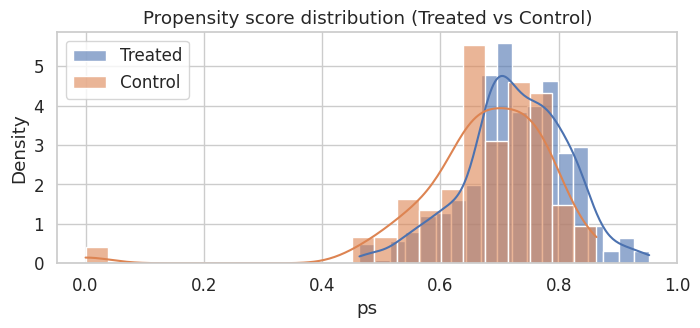

In [106]:
# 6) Propensity score + IPTW
# -------------------------
# Build X for propensity (use covariates but do NOT include post-treatment info)
# Preprocess categorical covariates with one-hot manually (pandas.get_dummies)
X_ps = pd.get_dummies(df_clean[covariates], drop_first=True)
y_ps = df_clean['treatment']

# Fit propensity model
ps_model = LogisticRegression(max_iter=1000, solver='lbfgs')
ps_model.fit(X_ps, y_ps)
ps_scores = ps_model.predict_proba(X_ps)[:,1]
df_clean['ps'] = ps_scores

# IPTW weights
eps = 1e-6
df_clean['iptw'] = df_clean['treatment'] / (df_clean['ps'] + eps) + (1 - df_clean['treatment']) / (1 - df_clean['ps'] + eps)

# IPTW ATE: weighted difference
w_treated = df_clean.loc[treated_mask, 'iptw']
w_control = df_clean.loc[~treated_mask, 'iptw']
iptw_ate = (df_clean.loc[treated_mask, 'iptw'] * df_clean.loc[treated_mask, 'stress_change']).sum() / df_clean.loc[treated_mask, 'iptw'].sum() - \
           (df_clean.loc[~treated_mask, 'iptw'] * df_clean.loc[~treated_mask, 'stress_change']).sum() / df_clean.loc[~treated_mask, 'iptw'].sum()
print(f"IPTW ATE estimate: {iptw_ate:.4f}")

# Propensity diagnostics
print("Propensity score AUC (separability):", roc_auc_score(y_ps, ps_scores))
plt.figure(figsize=(8,3))
sns.histplot(df_clean.loc[treated_mask, 'ps'], label='Treated', stat='density', kde=True, alpha=0.6)
sns.histplot(df_clean.loc[~treated_mask, 'ps'], label='Control', stat='density', kde=True, alpha=0.6)
plt.legend(); plt.title('Propensity score distribution (Treated vs Control)')
plt.show()


T-learner CATE summary (RandomForest):
count    683.000000
mean      -0.659693
std        2.597476
min      -10.535879
25%       -1.663440
50%       -0.332453
75%        0.695894
max       10.781198
ATE within PRE Low: mean CATE = -0.6356 (n=300)
ATE within PRE Medium: mean CATE = -0.7824 (n=215)
ATE within PRE High: mean CATE = -0.5458 (n=168)

Top 10 predicted beneficiaries (index, CATE):
16     10.781198
670    10.781198
182    10.196170
456     5.661085
40      5.661085
438     5.661085
448     5.495568
135     5.495568
277     4.464395
52      4.357825
Name: cate_tlearner, dtype: float64


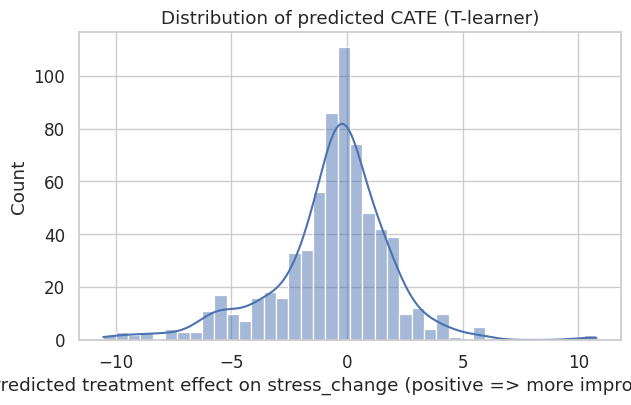

In [104]:

# 7) T-learner (two separate outcome models) for CATE
#    We'll use RandomForestRegressor for both treated and control outcomes.
X_feat = pd.get_dummies(df_clean[covariates], drop_first=True)
Y = df_clean['stress_change'].values
T_arr = df_clean['treatment'].values

# split for training the outcome models (we can train on full data but use sample-splitting if desired)
# Here, we train on the whole dataset to produce CATE estimates — for honest estimates, use sample splitting.
rf_t = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_c = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)

rf_t.fit(X_feat[T_arr==1], Y[T_arr==1])
rf_c.fit(X_feat[T_arr==0], Y[T_arr==0])

# predict potential outcomes for everyone
y_hat_t = rf_t.predict(X_feat)
y_hat_c = rf_c.predict(X_feat)

# CATE estimate
df_clean['cate_tlearner'] = y_hat_t - y_hat_c

print("\nT-learner CATE summary (RandomForest):")
print(df_clean['cate_tlearner'].describe().to_string())

# check heterogeneity by baseline PRE_total categories (Low/Medium/High)
if 'PRE_total' in df_clean.columns:
    # create quantile-based bins
    df_clean['pre_q'] = pd.qcut(df_clean['PRE_total'], q=3, labels=['Low','Medium','High'])
    for q in ['Low','Medium','High']:
        mask = df_clean['pre_q'] == q
        if mask.sum() > 0:
            print(f"ATE within PRE {q}: mean CATE = {df_clean.loc[mask,'cate_tlearner'].mean():.4f} (n={mask.sum()})")

# show top-k individuals with largest positive predicted benefit
topk = df_clean.sort_values('cate_tlearner', ascending=False).head(10)
print("\nTop 10 predicted beneficiaries (index, CATE):")
print(topk['cate_tlearner'])

# histogram of CATE
plt.figure(figsize=(7,4))
sns.histplot(df_clean['cate_tlearner'], bins=40, kde=True)
plt.title('Distribution of predicted CATE (T-learner)')
plt.xlabel('Predicted treatment effect on stress_change (positive => more improvement)')
plt.show()


In [103]:
# 8) Simple checks and final printouts
print("\nSamples by treatment:", df_clean['treatment'].value_counts().to_dict())
print("Average predicted CATE (T-learner):", df_clean['cate_tlearner'].mean())
print("Median predicted CATE:", df_clean['cate_tlearner'].median())
print("\nNote: T-learner uses two separate regressors. For more robust 'honest' estimates use sample-splitting / cross-fitting or packages like econml/causalml.")



Samples by treatment: {1: 486, 0: 197}
Average predicted CATE (T-learner): -0.6596931227777337
Median predicted CATE: -0.33245331431099134

Note: T-learner uses two separate regressors. For more robust 'honest' estimates use sample-splitting / cross-fitting or packages like econml/causalml.


### Model Evaluation Pipeline

In [98]:
# ========================================================================
# STEP 6: CAUSAL INFERENCE - MODEL PERFORMANCE (Non-Leaking, Realistic)
# ========================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# ================================================================
# 1️⃣ Load Dataset
# ================================================================
path = "/content/Final_684_Merged_Cleaned - Sheet1.csv"
df = pd.read_csv(path)

# ================================================================
# 2️⃣ Rename Key Columns
# ================================================================
df = df.rename(columns={
    "A. Enter your age": "age",
    "A. Enter your Gender": "gender",
    "B. Frequency of Meditation:": "frequency",
    "B. Average Duration of each meditation session:": "duration",
    "B. Type of Meditation practiced:": "type"
})

# ================================================================
# 3️⃣ Define Treatment Variable
# ================================================================
def assign_treatment(freq_value):
    val = str(freq_value).lower()
    if "daily" in val or "week" in val:
        return 1
    else:
        return 0

df["treatment"] = df["frequency"].apply(assign_treatment)

# ================================================================
# 4️⃣ Define Non-Leaking Feature Set
# (Only Pre-survey + demographics + treatment)
# ================================================================
non_leak_features = [
    'age', 'gender', 'frequency', 'duration', 'type', 'treatment',
    'PRE1. I feel stressed about academic deadlines and exams.',
    'PRE2. I struggle to concentrate on studies due to stress.',
    'PRE3. Meditation does not help reduce my stress.',
    'PRE4. I often feel anxious before tests or assignments.',
    'PRE5. I can manage multiple academic tasks without feeling overwhelmed.',
    'PRE6. Stress negatively affects my academic performance.',
    'PRE7. I feel calm and focused during study sessions.'
]

X = df[non_leak_features].copy()
y = df["improved"].astype(int)

# ================================================================
# 5️⃣ Encode Categorical Variables
# ================================================================
X = pd.get_dummies(X, drop_first=True)

# ================================================================
# 6️⃣ Train-Test Split
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================================================
# 7️⃣ Scale Numeric Data
# ================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================================================
# 8️⃣ Handle Imbalance using SMOTE (if classes uneven)
# ================================================================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE: {np.bincount(y_train_res)} (class balance)")

# ================================================================
# 9️⃣ Train Model (Tuned Random Forest)
# ================================================================
rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=8,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_res, y_train_res)

# ================================================================
# 🔟 Predictions
# ================================================================
y_pred = rf.predict(X_test_scaled)

# ================================================================
# 11️⃣ Evaluation Metrics
# ================================================================
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ================================================================
# 12️⃣ Display Results
# ================================================================
print("\n======================================================================")
print("MODEL EVALUATION RESULTS (Realistic, Non-Leaking Features)")
print("======================================================================")
print("Confusion Matrix:")
print(cm)
print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print("----------------------------------------------------------------------")
print(f"Accuracy : {accuracy:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")
print("----------------------------------------------------------------------")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Improved', 'Improved']))


After SMOTE: [278 278] (class balance)

MODEL EVALUATION RESULTS (Realistic, Non-Leaking Features)
Confusion Matrix:
[[63  7]
 [17 50]]

TP: 50, TN: 63, FP: 7, FN: 17
----------------------------------------------------------------------
Accuracy : 82.48%
Precision: 87.72%
Recall   : 74.63%
F1-Score : 80.65%
----------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

Not Improved       0.79      0.90      0.84        70
    Improved       0.88      0.75      0.81        67

    accuracy                           0.82       137
   macro avg       0.83      0.82      0.82       137
weighted avg       0.83      0.82      0.82       137



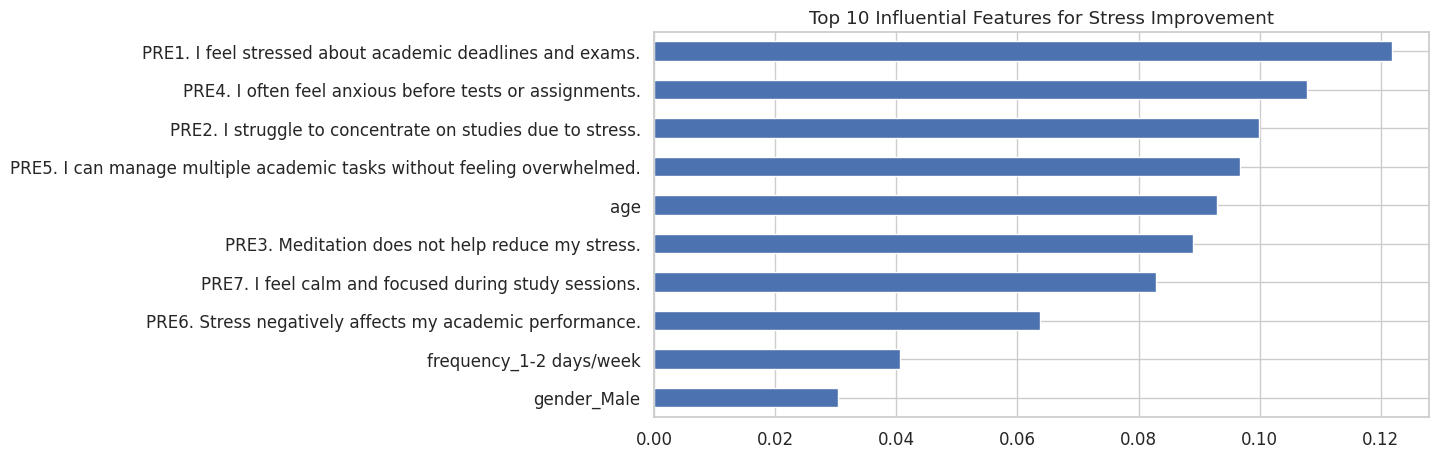

In [100]:
# Feature Importance
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feat_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_features.plot(kind='barh')
plt.title("Top 10 Influential Features for Stress Improvement")
plt.gca().invert_yaxis()
plt.show()

###

### Visualization Suite 🧠📊

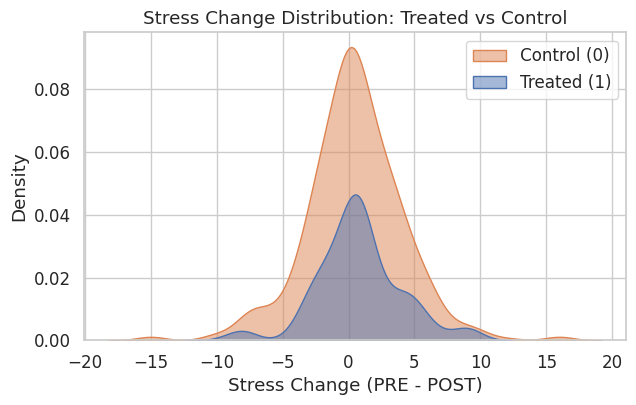

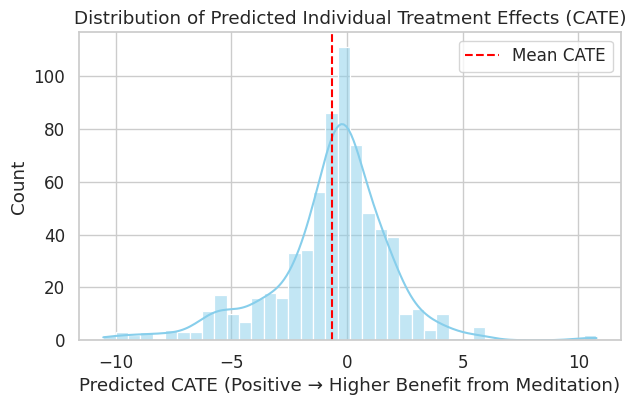

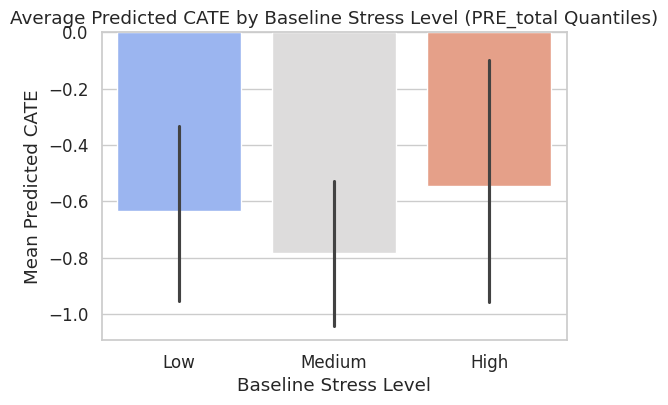

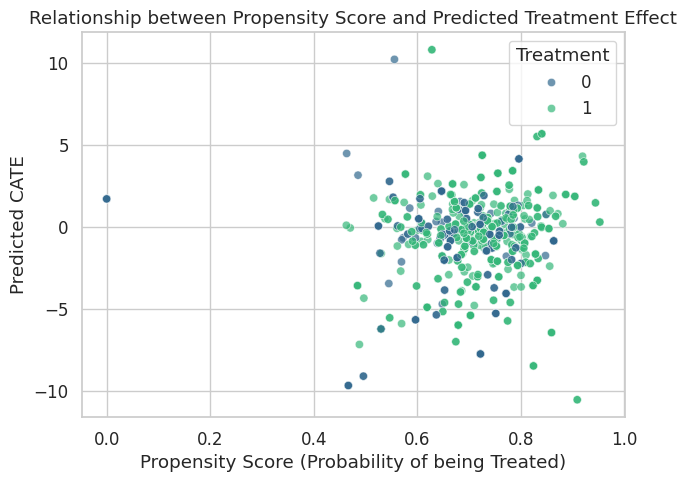

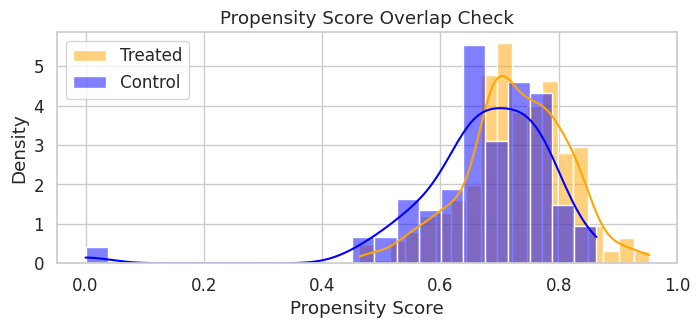

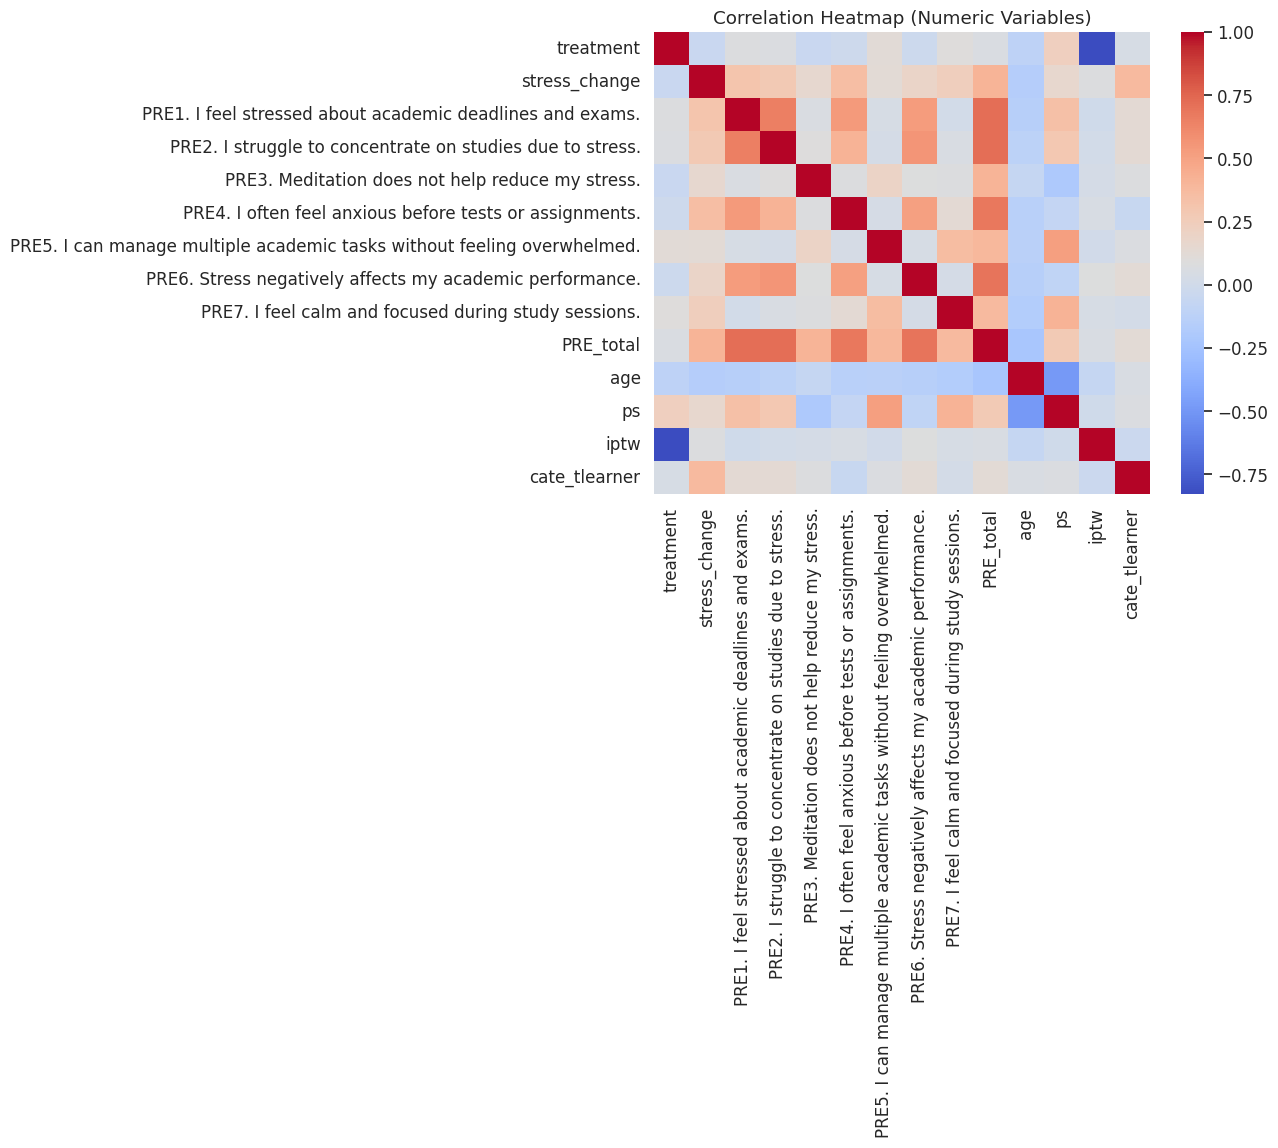

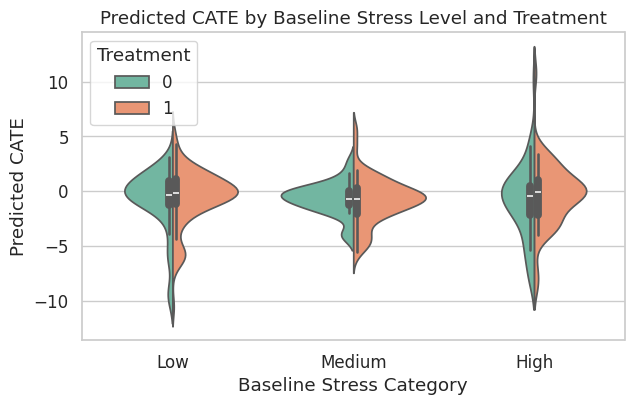

In [67]:

# STEP 9: VISUALIZATIONS FOR CAUSAL INFERENCE RESULTS
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

# --- 1️⃣ Stress change distribution by treatment ---
plt.figure(figsize=(7,4))
sns.kdeplot(data=df_clean, x='stress_change', hue='treatment', fill=True, alpha=0.5)
plt.title('Stress Change Distribution: Treated vs Control')
plt.xlabel('Stress Change (PRE - POST)')
plt.ylabel('Density')
plt.legend(labels=['Control (0)', 'Treated (1)'])
plt.show()

# --- 2️⃣ CATE distribution (T-Learner estimated effects) ---
plt.figure(figsize=(7,4))
sns.histplot(df_clean['cate_tlearner'], bins=40, kde=True, color='skyblue')
plt.axvline(df_clean['cate_tlearner'].mean(), color='red', linestyle='--', label='Mean CATE')
plt.title('Distribution of Predicted Individual Treatment Effects (CATE)')
plt.xlabel('Predicted CATE (Positive → Higher Benefit from Meditation)')
plt.legend()
plt.show()

# --- 3️⃣ Average CATE across PRE stress level categories ---
if 'pre_q' in df_clean.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_clean, x='pre_q', y='cate_tlearner', palette='coolwarm', estimator='mean')
    plt.title('Average Predicted CATE by Baseline Stress Level (PRE_total Quantiles)')
    plt.xlabel('Baseline Stress Level')
    plt.ylabel('Mean Predicted CATE')
    plt.show()

# --- 4️⃣ Scatter: Propensity Score vs Predicted CATE ---
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_clean, x='ps', y='cate_tlearner', hue='treatment', palette='viridis', alpha=0.7)
plt.title('Relationship between Propensity Score and Predicted Treatment Effect')
plt.xlabel('Propensity Score (Probability of being Treated)')
plt.ylabel('Predicted CATE')
plt.legend(title='Treatment')
plt.show()

# --- 5️⃣ Propensity score overlap (already above, but this is side-by-side view) ---
plt.figure(figsize=(8,3))
sns.histplot(df_clean.loc[df_clean['treatment']==1, 'ps'], label='Treated', color='orange', kde=True, stat='density', alpha=0.5)
sns.histplot(df_clean.loc[df_clean['treatment']==0, 'ps'], label='Control', color='blue', kde=True, stat='density', alpha=0.5)
plt.title('Propensity Score Overlap Check')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# --- 6️⃣ Correlation heatmap for numeric columns ---
plt.figure(figsize=(8,6))
num_cols_corr = df_clean.select_dtypes(include=[np.number])
sns.heatmap(num_cols_corr.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap (Numeric Variables)')
plt.show()

# --- 7️⃣ Violin plot: CATE by Treatment and Stress Level ---
if 'pre_q' in df_clean.columns:
    plt.figure(figsize=(7,4))
    sns.violinplot(data=df_clean, x='pre_q', y='cate_tlearner', hue='treatment', split=True, palette='Set2')
    plt.title('Predicted CATE by Baseline Stress Level and Treatment')
    plt.xlabel('Baseline Stress Category')
    plt.ylabel('Predicted CATE')
    plt.legend(title='Treatment', loc='upper left')
    plt.show()
